In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [46]:
def finDif(omega, f, n, bc):
    h = ( omega[1] - omega[0] ) / ( n-1 )  # define the step size

    x = np.array([i*h for i in range(n)])  # define the discrete points in the interval
    
    b = np.array( f(x) )  # define the input function at the chosen points
    b[0], b[n-1] = bc  # impose the input boundary conditions

    A = ( np.diag([-1 for i in range(0,n-2)], -2) \
        + np.diag([16 for i in range(0,n-1)], -1) \
        + np.diag([-30 for i in range(0,n)]) \
        + np.diag([16 for i in range(0,n-1)], 1) \
        + np.diag([-1 for i in range(0,n-2)], 2) ) * ( - 1 / (12*h**2) )
    return A, b

Call the function using:

In [28]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc) 

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

Using the Gauss method to perform the LU decomposition of a matrix A:

$$ l_{i,k} = \frac{ a_{i,k}^{(k)} } { a_{k,k}^{(k)} } $$

$$ a_{i,j}^{(k+1)} = a_{i,j}^{(k)} - l_{i,k} * a_{k,j}^{(k)} $$

In [29]:
def LU(A, pivot = False):
    '''
    If pivot = False -> Gauss method
    '''
    A = np.array(A, dtype="float64")
    n = A.shape[0]
    L = np.zeros((n,n))

    P = np.identity(n) if pivot else None

    for k in range(n-1):
        if pivot:  # pivoting done only if asked by user
            assert( A[k, k] != 0 ), "Division by zero"
            piv = k + abs(A[k:, k]).argmax()   # looking at best pivot
            
            # exchange rows and columns
            A[[k, piv]] = A[[piv, k]]
            L[[k, piv]] = L[[piv, k]]

            P_k= np.identity(n)  # inizialization new permutation matrix in step k
            P_k[[k, piv]] = P_k[[piv, k]]  # exchanging rows and columns
            P = np.dot(P, P_k)  # updating total permutation matrix
        
        assert( A[k, k] != 0 ), "Division by zero"
        L[k+1:, k] = A[k+1:, k] / A[k, k]
        A[k+1:] -= L[k+1:, k][:, None] * A[k, :]

    np.fill_diagonal(L, 1)

    if pivot:
        return L, A, P

    return L, A

L, U = LU(A)

In [30]:
def cholesky(A):
    A = np.array(A, dtype="float64")
    L = np.zeros_like(A)
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, A.shape[0]):
        for j in range(i):
            L[j, i] = ( A[i, j] - np.dot( L[:j, i], L[:j, j] ) ) / L[j, j]
        L[i, i] = np.sqrt( A[i, i] - np.dot( L[:i, i], L[:i, i] ) )
    
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [31]:
def L_solve(L, rhs):
    assert L.shape[0] == L.shape[1], "The input matrix is not square"
    
    L = np.array(L, dtype="float64")
    rhs = np.array(rhs, dtype="float64")
    x = np.zeros_like(rhs, dtype="float64")
    
    x[0] = rhs[0] / L[0, 0]
    for i in range(1, L.shape[0]):
        assert L[i, i] != 0, "Invalid operation: diagonal element in L equal to 0"
        x[i] = ( rhs[i] - np.dot(L[i, :i], x[:i] ) ) / L[i, i]

    return x

In [32]:
def U_solve(U, rhs):
    assert U.shape[0] == U.shape[1], "The input matrix is not square"
    
    U = np.array(U, dtype="float64")
    rhs = np.array(rhs, dtype="float64")
    x = np.zeros_like(rhs, dtype="float64")
    
    x[U.shape[0] - 1] = rhs[U.shape[0] - 1] / U[U.shape[0] - 1, U.shape[0] - 1]
    for i in range(U.shape[0]-1 , -1, -1):
        assert U[i, i] != 0, "Invalid operation: diagonal element in U equal to 0"
        x[i] = ( rhs[i] - np.dot(U[i, i+1:], x[i+1:]) ) / U[i, i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

In [38]:
def solve_system(A, b, pivot=False):
    assert A.shape[0] == A.shape[1], "Not square input matrix"
    
    if pivot:
        L, U, P = LU(A, pivot=pivot)
    else:
        L, U = LU(A)
        P = np.identity(A.shape[0])

    y = L_solve(L, np.matmul(b, P))
    x = U_solve(U, y)
    
    return x

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [34]:
def solve(omega, f, n, bc):
    A, b = finDif(omega, f, n, bc)
    f_solve = solve_system(A, b, pivot=True)
    x = np.linspace(omega[0], omega[1], num=f_solve.shape[0]) # discretization points
    return x, f_solve

In [44]:
def plot_error(omega, f, bc, f_real):
    N = np.arange(50, 1200, step=200)
    er = np.zeros(N.shape[0])
    i = 0

    for n in N:
        x, f_solve = solve(omega, f, n, bc)
        er[i] = max( abs( f_solve - f_real(x) ) )
        i += 1
    
    plt.plot(N, er, label = "${\\Vert \\cdot \\Vert}_{\\infty}$")
    plt.xlabel("Iteration", fontsize=15)
    plt.ylabel("Error", fontsize=15, rotation=0, labelpad=20)
    plt.legend()
    plt.yscale("log")
    plt.title("Error vs number of iteartions", fontsize=18)
    plt.grid()

    return pd.DataFrame({"Iteration":N, "Error":er})


,Iteration,Error
0,50,0.001578
1,250,0.000311
2,450,0.000172
3,650,0.000119
4,850,0.000091
5,1050,0.000074


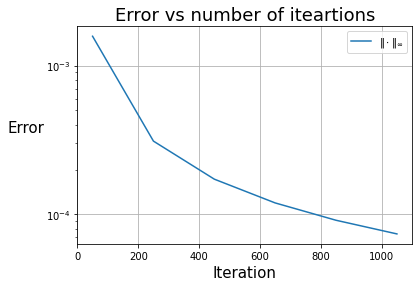

In [47]:
omega = [0,1]
bc = [0,0]
f = lambda x : x*(1-x)
f_real = lambda x: np.power(x,4) / 12 - np.power(x,3) / 6 + x / 12
error = plot_error(omega, f, bc, f_real)
error

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [ ]:
def inverse(A):
    A = np.array(A, dtype="float64")
    inv_A = np.zeros_like(A)
    I = np.identity(A.shape[0])
    L, U, P = LU(A, pivot=True)
    
    for k in range(A.shape[0]):
        tmp = L_solve(L, np.matmul(I[:, k],P))
        inv_A[:, k] = U_solve(U, tmp)
    return inv_A

In [ ]:
def condNumb(A):
    A = np.array(A)
    A_inv = inverse(A)
    condNu = max( sum( abs(A), axis=1) ) * max( sum( abs(A_inv), axis=1) )
    return condNu 

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [ ]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    pass #TODO

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
#TODO

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [ ]:
#TODO

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
#TODO

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [ ]:
#TODO